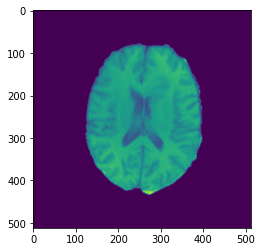

In [1]:
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
ds = dcmread("data/train/00000/T1w/Image-20.dcm")
arr = ds.pixel_array

plt.imshow(arr)
plt.show()

In [2]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv('data/train_labels.csv')
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


<AxesSubplot:xlabel='MGMT_value', ylabel='count'>

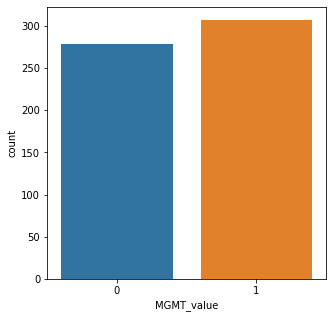

In [4]:
plt.figure(figsize=(5,5))
sns.countplot(data=train_df, x="MGMT_value")

In [5]:
def load_dicom(path):
    # input is file path
    dicom = pydicom.read_file(path)  # read data
    data = dicom.pixel_array  # to np array
    data = data - np.min(data)  # normalize
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)  # make 0 to 255 int for image
    return data  # return np int array

def visualize_sample(
    brats21id,  # patient id
    slice_i,  # image index (0.5=middle)
    mgmt_value,  # target value cancerous or not
    types=("FLAIR", "T1w", "T1wCE", "T2w")  # image types
):
    plt.figure(figsize=(16, 5))  # create figure
    patient_path = os.path.join(  # create file path
        "data/train/",
        str(brats21id).zfill(5),  # pad with zeros
    )
    for i, t in enumerate(types, 1):  # for 4 scan types
        t_paths = sorted(  # sorted list of paths
            glob.glob(os.path.join(patient_path, t, "*")), # get scans in file
            key=lambda x: int(x[:-4].split("-")[-1]),  # sort in numerical order
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])  # get int array
        plt.subplot(1, 4, i)  # create sub plot 1 by 4
        plt.imshow(data, cmap="gray")  # add image to plot
        plt.title(f"{t}", fontsize=16)  # add subplot title
        plt.axis("off")  # no axis

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

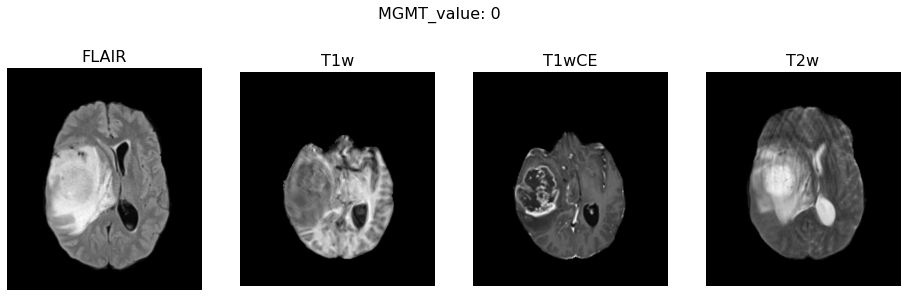

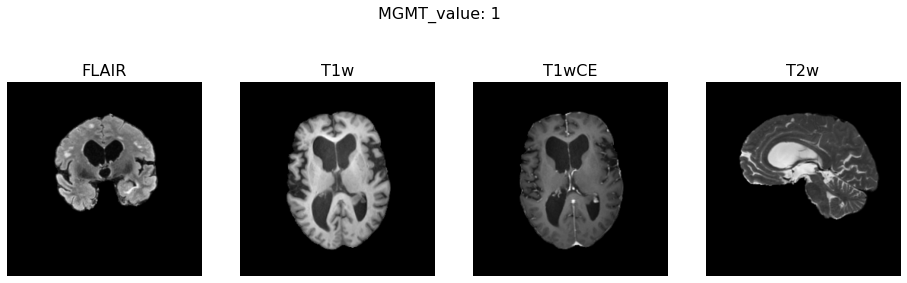

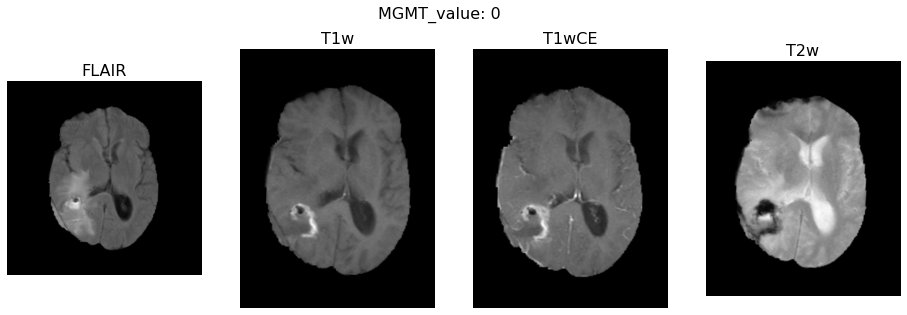

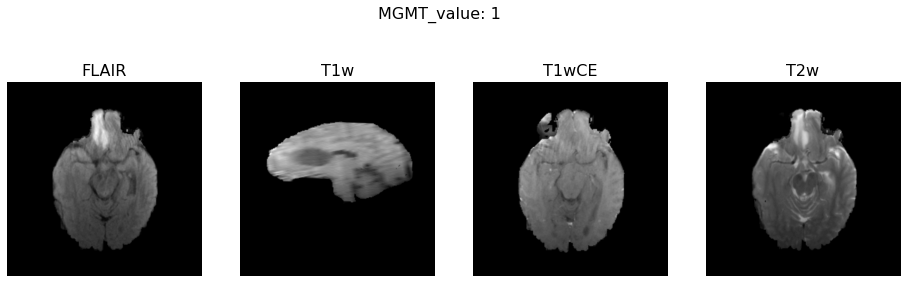

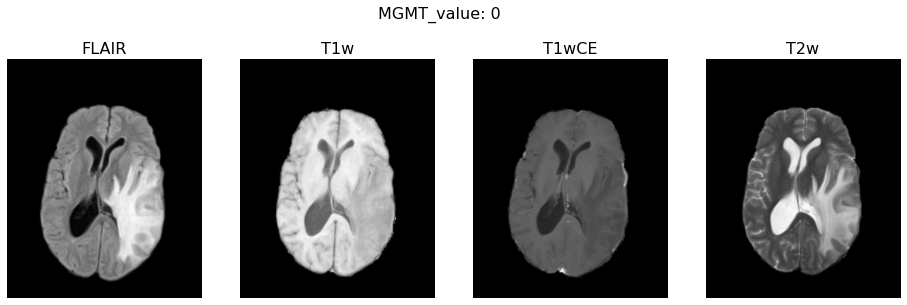

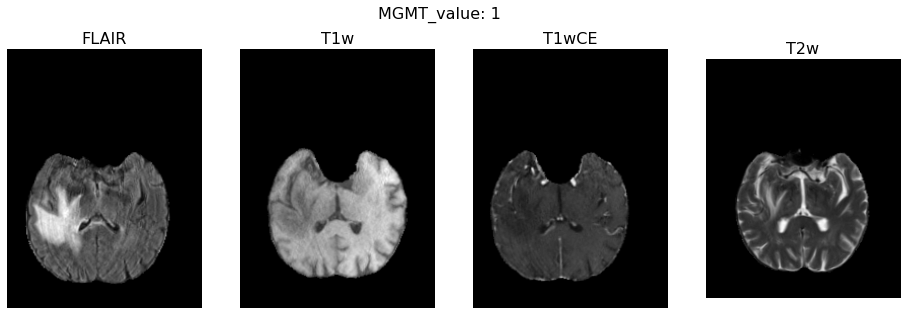

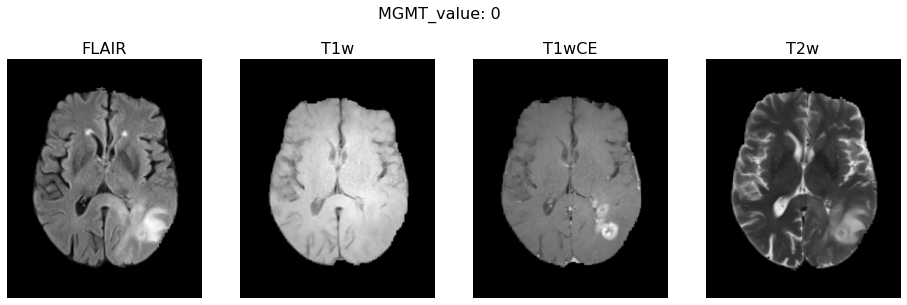

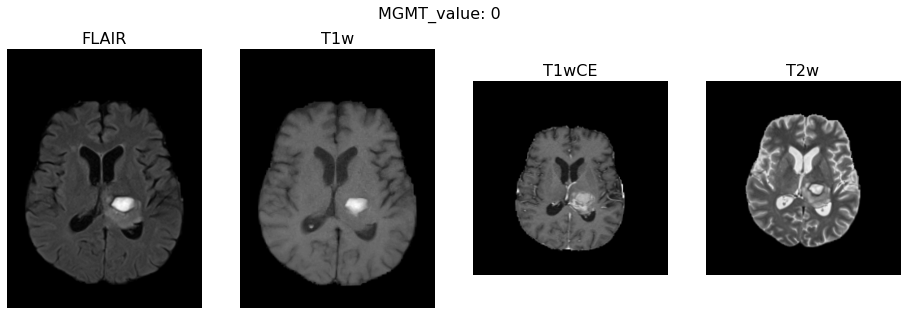

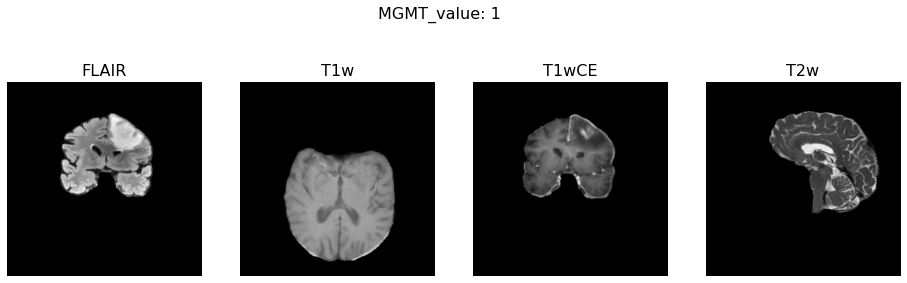

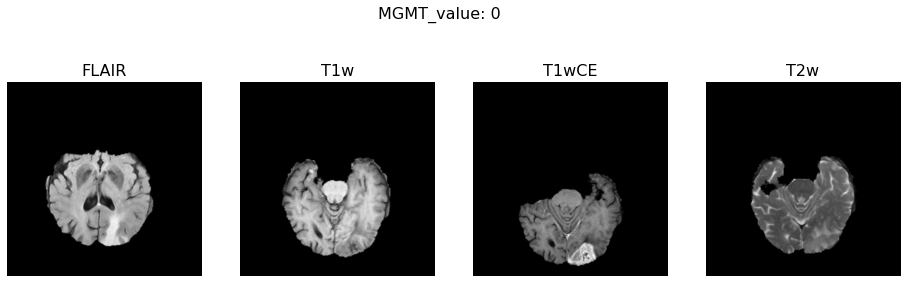

In [6]:
for i in random.sample(range(train_df.shape[0]), 10):
    _brats21id = train_df.iloc[i]["BraTS21ID"]
    _mgmt_value = train_df.iloc[i]["MGMT_value"]
    visualize_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5)

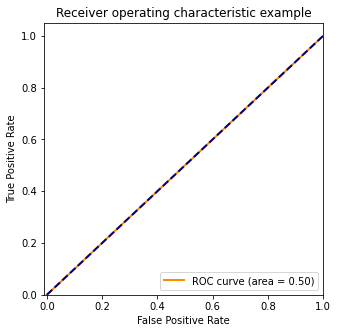

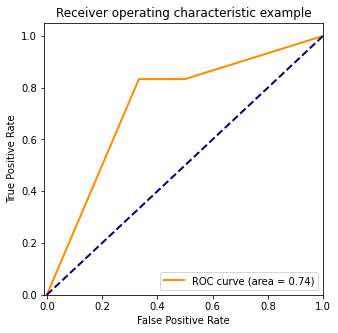

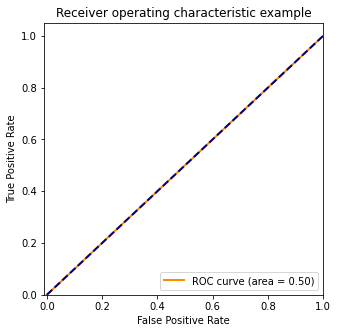

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

list_y_true = [  # Example target data
    [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], #  IMBALANCE
]
list_y_pred = [  # Example predictions
    [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    [0.9, 0.9, 0.9, 0.9, 0.1, 0.9, 0.9, 0.1, 0.9, 0.1, 0.1, 0.5],
    [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], #  IMBALANCE
]

for y_true, y_pred in zip(list_y_true, list_y_pred):  # loop through graphs
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # get false positive rate and true positive rate
    roc_auc = auc(fpr, tpr)  # get area under the curve stat

    plt.figure(figsize=(5, 5))  # create figure 
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
submission = pd.read_csv("data/sample_submission.csv")
# submission.to_csv("submission.csv", index=False)
submission


,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


In [10]:
package_path = "input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/"
import sys 
sys.path.append(package_path)

import time

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import efficientnet_pytorch

from sklearn.model_selection import StratifiedKFold

In [11]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

In [12]:
# Get labels
# Split into train and validation sets
df = pd.read_csv("data/train_labels.csv")
df_train, df_valid = sk_model_selection.train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [13]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths  # Id values
        self.targets = targets  # Target MGMT values
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]  # Get ID
        patient_path = f"data/train/{str(_id).zfill(5)}/"  # Get path
        channels = []
        for t in ("FLAIR", "T1w", "T1wCE"): # "T2w"  # Cycle through data types
            t_paths = sorted(  # Get sorted list of file paths
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            # start, end = int(len(t_paths) * 0.475), int(len(t_paths) * 0.525)
            x = len(t_paths)  # Get number of paths
            if x < 10:
                r = range(x)  # Set range of paths
            else:
                d = x // 10  # Sample every 10th image
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:  # Loop through images. Downsample, normalize, and append. 
                channel.append(cv2.resize(load_dicom(t_paths[i]), (256, 256)) / 255)
            channel = np.mean(channel, axis=0)  # take average
            channels.append(channel)  # append average
            
        y = torch.tensor(self.targets[index], dtype=torch.float)  # Targets to tensor
        
        return {"X": torch.tensor(channels).float(), "y": y}  # provide X and y

In [14]:
# Create dataset instances
train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

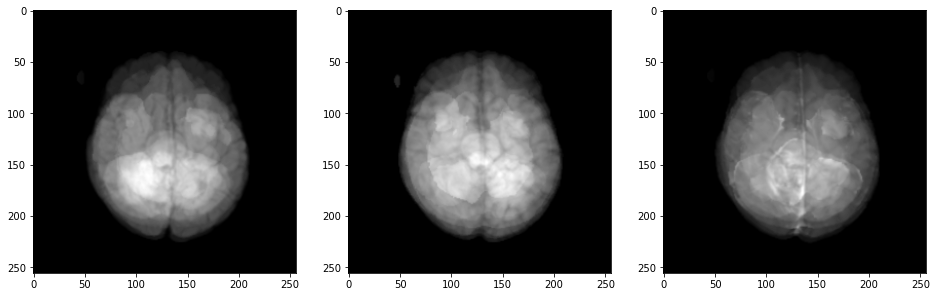

In [15]:
# Visualize images returned by DataRetriever
plt.figure(figsize=(16, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_data_retriever[100]["X"].numpy()[i], cmap="gray")

In [16]:
# Model extentends nn.Module
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # use EfficientNet
        self.net = efficientnet_pytorch.EfficientNet.from_name("efficientnet-b0")
        # Load weights
        # checkpoint = torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth")
        # self.net.load_state_dict(checkpoint)
        # Get number of features in model
        n_features = self.net._fc.in_features
        # Add fully connected layer going from efficientnet to one out value
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [17]:
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg


In [21]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = -np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if True:
#             if self.best_valid_score < valid_score:
                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=8,
    shuffle=True,
    num_workers=4,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=8,
    shuffle=False,
    num_workers=4,
)

model = Model()
model.to(device)

optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
criterion = torch_functional.binary_cross_entropy_with_logits

trainer = Trainer(
    model, 
    device, 
    optimizer, 
    criterion, 
    LossMeter, 
    AccMeter
)

history = trainer.fit(
    20, 
    train_loader, 
    valid_loader, 
    f"best-model-0.pth", 
    100,
)

EPOCH: 1
[Epoch Train: 1] loss: 0.69617, score: 0.50000, time: 23 s
[Epoch Valid: 1] loss: 0.69274, score: 0.52137, time: 6 s
The score improved from -inf to 0.52137. Save model to 'best-model-0.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.69284, score: 0.46581, time: 23 s
[Epoch Valid: 2] loss: 0.69269, score: 0.52137, time: 5 s
The score improved from 0.52137 to 0.52137. Save model to 'best-model-0.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.69171, score: 0.52564, time: 23 s
[Epoch Valid: 3] loss: 0.69259, score: 0.52137, time: 5 s
The score improved from 0.52137 to 0.52137. Save model to 'best-model-0.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.69326, score: 0.52350, time: 22 s
[Epoch Valid: 4] loss: 0.69251, score: 0.52137, time: 5 s
The score improved from 0.52137 to 0.52137. Save model to 'best-model-0.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.69470, score: 0.50855, time: 23 s
[Epoch Valid: 5] loss: 0.69248, score: 0.52137, time: 5 s
The score improved from 0.52137 to 0.52137. Save model to 'best-m

In [19]:
models = []
for i in range(1):
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(f"best-model-{i}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    models.append(model)

In [20]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths):
        self.paths = paths
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = f"data/test/{str(_id).zfill(5)}/"
        channels = []
        for t in ("FLAIR", "T1w", "T1wCE"): # "T2w"
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            # start, end = int(len(t_paths) * 0.475), int(len(t_paths) * 0.525)
            x = len(t_paths)
            if x < 10:
                r = range(x)
            else:
                d = x // 10
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:
                channel.append(cv2.resize(load_dicom(t_paths[i]), (256, 256)) / 255)
            channel = np.mean(channel, axis=0)
            channels.append(channel)
        
        return {"X": torch.tensor(channels).float(), "id": _id}

In [21]:
submission = pd.read_csv("data/sample_submission.csv")

test_data_retriever = DataRetriever(
    submission["BraTS21ID"].values, 
)

test_loader = torch_data.DataLoader(
    test_data_retriever,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)

In [22]:
y_pred = []
ids = []

for e, batch in enumerate(test_loader):
    print(f"{e}/{len(test_loader)}", end="\r")
    with torch.no_grad():
        tmp_pred = np.zeros((batch["X"].shape[0], ))
        for model in models:
            tmp_res = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            tmp_pred += tmp_res
        y_pred.extend(tmp_pred)
        ids.extend(batch["id"].numpy().tolist())

In [23]:
submission = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred})
submission.to_csv("submission.csv", index=False)

In [26]:
submission

,BraTS21ID,MGMT_value
0,1,0.502099
1,13,0.502099
2,15,0.502099
3,27,0.502099
4,37,0.502099
...,...,...
82,826,0.502099
83,829,0.502099
84,833,0.502099
85,997,0.502099


In [22]:
efficientnet_pytorch.EfficientNet.from_name("efficientnet-b0")

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=